In [1]:
import IPython
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly as py
from plotly.offline import download_plotlyjs
import pylab
import scipy
import seaborn as sns
import sklearn
from sklearn import *
import statsmodels as sm

np.random.seed(1337)

%matplotlib inline

IPython.core.display.display(IPython.core.display.HTML(
    "<style>.container { width:90% !important; }</style>"))

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

pd.options.display.max_colwidth = 30
pd.options.display.float_format = '{:,.3f}'.format

py.offline.init_notebook_mode(connected=True)

## Load the data

In [2]:
movies = pd.read_csv('data/movies_clean.csv')
ratings = pd.read_csv('data/ratings_train.csv')

In [3]:
# filter out users and movies with too few ratings
min_user_ratings = 50
min_movie_ratings = 300

user_rating_counts = ratings.groupby('user_id').movie_id.count()
print(user_rating_counts.quantile([0.2 * i for i in range(6)]))
user_ids = user_rating_counts[user_rating_counts > min_user_ratings].index.tolist()

movie_rating_counts = ratings.groupby('movie_id').user_id.count()
print(movie_rating_counts.quantile([0.2 * i for i in range(6)]))
movie_ids = movie_rating_counts[movie_rating_counts > min_movie_ratings].index.tolist()

ratings = ratings[(ratings.user_id.isin(user_ids)) & (ratings.movie_id.isin(movie_ids))]
movies = movies[movies.movie_id.isin(movie_ids)]

0.000       9.000
0.200      24.000
0.400      41.000
0.600      74.000
0.800     154.000
1.000   7,418.000
Name: movie_id, dtype: float64
0.000        1.000
0.200        2.000
0.400        7.000
0.600       42.000
0.800      297.000
1.000   53,894.000
Name: user_id, dtype: float64


# Calculate similarities on top movies

## Select movies to calculate similarity on

In [4]:
n_movies = 40

In [5]:
movie_rating_counts = pd.DataFrame(ratings.groupby(['movie_id']).user_id.count())
movie_rating_counts.columns = ['rating_count']
movies = movies.merge(movie_rating_counts, left_on='movie_id', right_index=True)
top_movie_ids = movies.sort_values('rating_count', ascending=False).head(n_movies).movie_id.tolist()
movies.sort_values('rating_count', ascending=False).head(n_movies)[['movie_id', 'title', 'rating_count']]

,movie_id,title,rating_count
352,356,Forrest Gump (1994),38413
293,296,Pulp Fiction (1994),38038
587,593,"Silence of the Lambs, The ...",36321
476,480,Jurassic Park (1993),35192
315,318,"Shawshank Redemption, The ...",34919
257,260,Star Wars: Episode IV - A ...,33340
2486,2571,"Matrix, The (1999)",33324
583,589,Terminator 2: Judgment Day...,32050
108,110,Braveheart (1995),31815
1171,1196,Star Wars: Episode V - The...,30922


## Select users who have enough ratings

In [6]:
user_rating_counts = ratings[ratings.movie_id.isin(top_movie_ids)].groupby('user_id').movie_id.count()
user_ids = user_rating_counts[user_rating_counts >= (n_movies/2)].index.tolist()
print('number of users who have enough ratings: ', len(user_ids))

number of users who have enough ratings:  22363


## Prepare the data for similarity computation

In [7]:
# get dense rating matrix
r = ratings[(ratings.user_id.isin(user_ids)) & (ratings.movie_id.isin(top_movie_ids))][['user_id', 'movie_id', 'rating']]
r = r.pivot(index='user_id', columns='movie_id').sort_index()
print(r.shape)
r.head(10)

(22363, 40)


rating                                                        ...   \
movie_id   1     32    47    50    110   150   260   296   318   356   ...    
user_id                                                                ...    
11        4.500 5.000   nan   nan 4.000 5.000 5.000 3.500 5.000 5.000  ...    
22        3.000   nan 4.000 4.000 4.000   nan   nan 5.000 5.000   nan  ...    
24        4.000   nan 4.000 5.000 4.000 3.000 5.000 5.000 5.000 5.000  ...    
25          nan 3.500 3.000 3.500 3.500   nan   nan 4.000 4.000 4.000  ...    
54        4.000 5.000 4.000 4.000 5.000   nan 4.000   nan 5.000 5.000  ...    
58        5.000   nan 5.000 5.000 5.000   nan   nan 5.000 5.000 4.500  ...    
69          nan 5.000   nan 4.000   nan   nan 5.000   nan   nan 4.000  ...    
90        3.500   nan 4.500   nan   nan 3.500 3.500 3.500 4.000 5.000  ...    
91        4.000 4.000   nan 3.500 5.000   nan 4.500 3.500 4.000 4.000  ...    
96        3.500 4.000 4.000 3.000   nan   nan 4.000 4.500 4.500 3.500  ...    

                                                                      
movie_id  1265  1270  1580  2028  2571  2762  2858  2959  3578  4993  
user_id                                                               
11         nan 5.000   nan 5.000   nan   nan   nan 4.500 4.500 5.000  
22         nan   nan 3.000 3.000 3.000   nan 3.000 4.000   nan   nan  
24       3.000 4.000 5.000 5.000 5.000 5.000 5.000 5.000 5.000   nan  
25       3.500   nan 1.500 3.500 3.500   nan   nan 4.000 3.500 3.500  
54       3.000   nan   nan 5.000 5.000   nan 5.000   nan 4.000   nan  
58         nan   nan 4.000 5.000 5.000 5.000 4.500 5.000   nan 5.000  
69         nan 3.000   nan   nan   nan   nan   nan   nan   nan   nan  
90         nan   nan   nan 2.500 2.000 4.000 5.000 2.000 3.500   nan  
91       4.500 4.000   nan 4.000 3.500 4.000 4.500 5.000 3.500 5.000  
96         nan 4.500   nan 4.000 4.500 4.500   nan   nan 3.500 4.000  

[10 rows x 40 columns]

In [8]:
# normalize ratings by user ratings average
user_mean_ratings = ratings[ratings.user_id.isin(user_ids)][['user_id', 'rating']].groupby('user_id').rating.mean().sort_index()
print(user_mean_ratings.head(10))
for movie_id in r.columns:
    r[movie_id] -= user_mean_ratings.values
r.fillna(0, inplace=True)
print(r.shape)
r.head(10)

user_id
11   4.045
22   3.620
24   3.376
25   3.635
54   3.427
58   4.160
69   3.148
90   3.515
91   3.399
96   3.487
Name: rating, dtype: float64
(22363, 40)


rating                                                               \
movie_id   1      32     47     50     110    150    260    296   318   356    
user_id                                                                        
11        0.455  0.955  0.000  0.000 -0.045  0.955  0.955 -0.545 0.955 0.955   
22       -0.620  0.000  0.380  0.380  0.380  0.000  0.000  1.380 1.380 0.000   
24        0.624  0.000  0.624  1.624  0.624 -0.376  1.624  1.624 1.624 1.624   
25        0.000 -0.135 -0.635 -0.135 -0.135  0.000  0.000  0.365 0.365 0.365   
54        0.573  1.573  0.573  0.573  1.573  0.000  0.573  0.000 1.573 1.573   
58        0.840  0.000  0.840  0.840  0.840  0.000  0.000  0.840 0.840 0.340   
69        0.000  1.852  0.000  0.852  0.000  0.000  1.852  0.000 0.000 0.852   
90       -0.015  0.000  0.985  0.000  0.000 -0.015 -0.015 -0.015 0.485 1.485   
91        0.601  0.601  0.000  0.101  1.601  0.000  1.101  0.101 0.601 0.601   
96        0.013  0.513  0.513 -0.487  0.000  0.000  0.513  1.013 1.013 0.013   

          ...                                                                  \
movie_id  ...     1265   1270   1580   2028   2571  2762   2858   2959   3578   
user_id   ...                                                                   
11        ...    0.000  0.955  0.000  0.955  0.000 0.000  0.000  0.455  0.455   
22        ...    0.000  0.000 -0.620 -0.620 -0.620 0.000 -0.620  0.380  0.000   
24        ...   -0.376  0.624  1.624  1.624  1.624 1.624  1.624  1.624  1.624   
25        ...   -0.135  0.000 -2.135 -0.135 -0.135 0.000  0.000  0.365 -0.135   
54        ...   -0.427  0.000  0.000  1.573  1.573 0.000  1.573  0.000  0.573   
58        ...    0.000  0.000 -0.160  0.840  0.840 0.840  0.340  0.840  0.000   
69        ...    0.000 -0.148  0.000  0.000  0.000 0.000  0.000  0.000  0.000   
90        ...    0.000  0.000  0.000 -1.015 -1.515 0.485  1.485 -1.515 -0.015   
91        ...    1.101  0.601  0.000  0.601  0.101 0.601  1.101  1.601  0.101   
96        ...    0.000  1.013  0.000  0.513  1.013 1.013  0.000  0.000  0.013   

                 
movie_id   4993  
user_id          
11        0.955  
22        0.000  
24        0.000  
25       -0.135  
54        0.000  
58        0.840  
69        0.000  
90        0.000  
91        1.601  
96        0.513  

[10 rows x 40 columns]

## Calculate similarities

[11  7  6  6  3  1  4  6  6  3 10 14 16  2 17  6 10  4 13 19  6  6 15  6
 12  6  4  4  4  4  9  4 18  3  6  8  6  6  3  5]


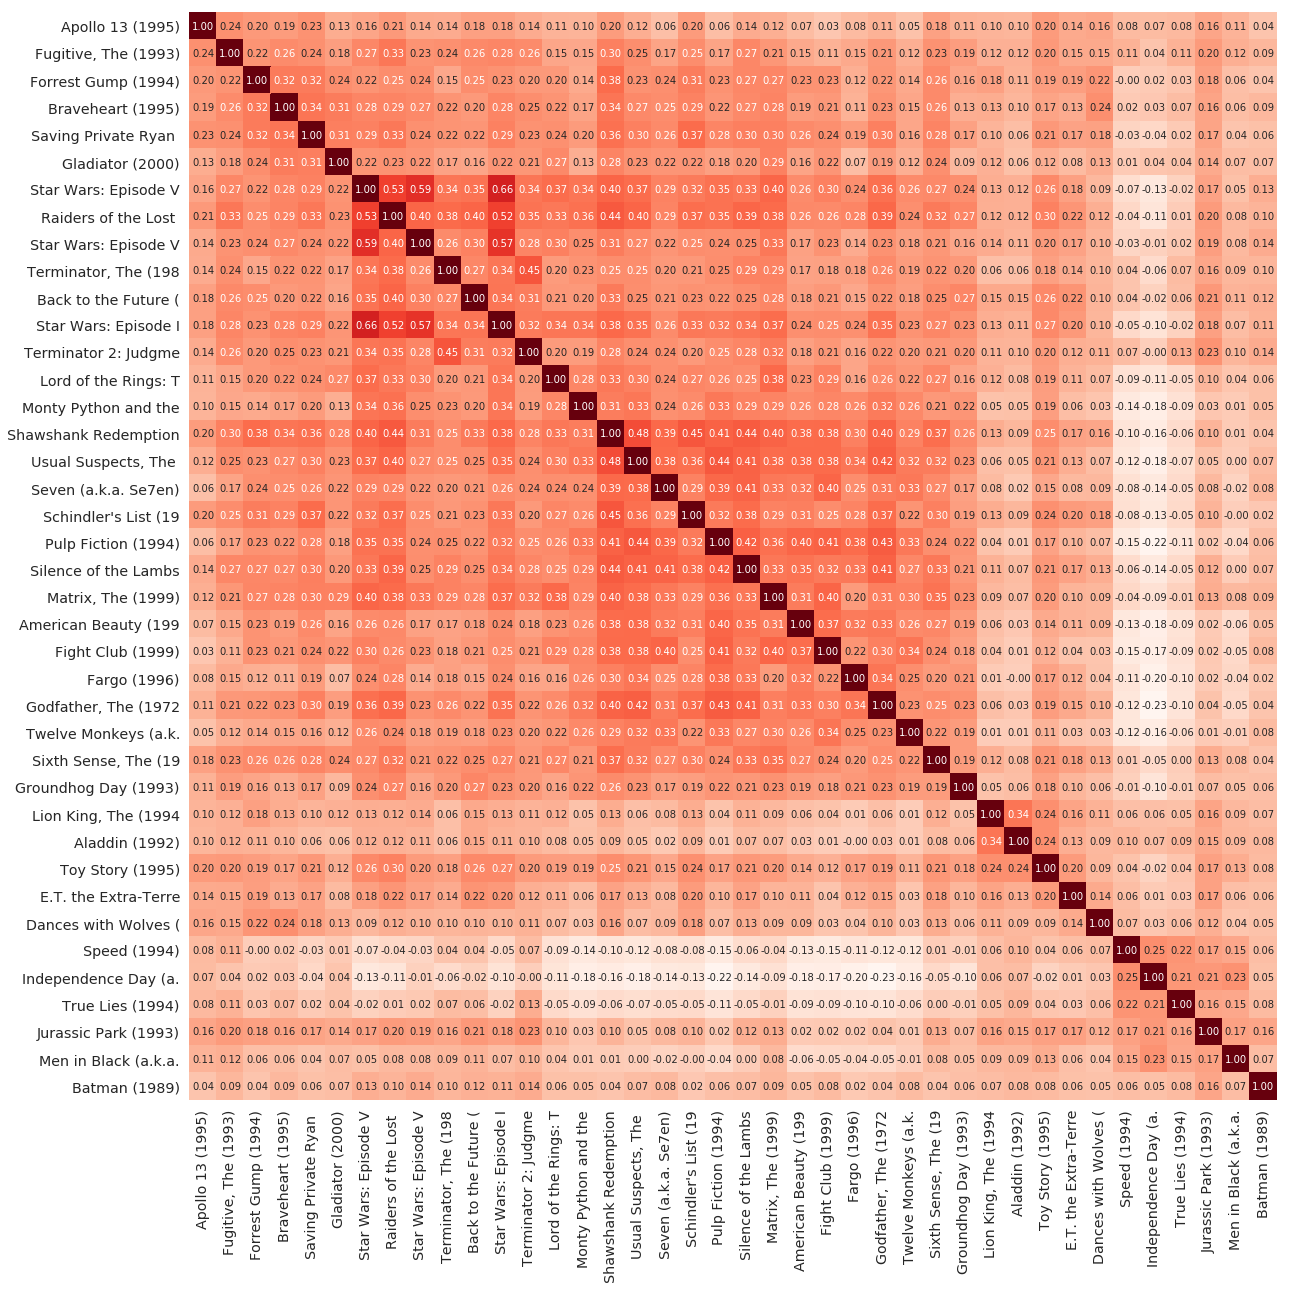

In [9]:
# calculate similarities
s = sklearn.metrics.pairwise.cosine_similarity(r.T)
titles = [title[:20] for title in movies[movies.movie_id.isin(top_movie_ids)].title.tolist()]

# hierarchical clustering to move similar items next to each other for better visualization
t = np.round((1 - s) / np.max(1 - s), decimals=3)
labels = scipy.cluster.hierarchy.fcluster(
            scipy.cluster.hierarchy.linkage(
                scipy.spatial.distance.squareform(t),
                method='average'),
            0.58,
            criterion='distance')
print(labels)
for i in range(n_movies):
    for j in range(i+1, n_movies):
        if labels[i] > labels[j]:
            labels[i], labels[j] = labels[j], labels[i]
            titles[i], titles[j] = titles[j], titles[i]
            
            tmp = np.copy(s[i,:])
            s[i,:] = s[j,:]
            s[j,:] = tmp
            
            tmp = np.copy(s[:,i])
            s[:,i] = s[:,j]
            s[:,j] = tmp

# plot similarity matrix
plt.figure(figsize=(20, 20))
sns.heatmap(
    data=s,
    vmin=np.min(s),
    vmax=np.max(s),
    cbar=False,
    square=True,
    annot=True,
    fmt='.2f',
    xticklabels=titles,
    yticklabels=titles,
    cmap='Reds')
plt.show()

# Find similar items to a movie

In [10]:
def similar_movies(source_movie_id, min_ratings=10, n_results=6):
    print('finding similar movies to: ', movies[movies.movie_id == source_movie_id].title.tolist()[0])
    
    # find users that rated the movie
    user_ids = ratings[ratings.movie_id == source_movie_id].user_id.unique()
    print('number of users that rated the movie: ', len(user_ids))
    
    # find movies that have enough ratings among these users
    ratings_by_users = ratings[ratings.user_id.isin(user_ids)]
    movie_rating_counts = ratings_by_users.groupby('movie_id').user_id.count()
    candidate_movie_ids = movie_rating_counts[movie_rating_counts >= min_ratings].index.tolist()
    print('number of candidate movies that have enough ratings: ', len(candidate_movie_ids))
    
    # get dense rating matrix
    r = ratings[(ratings.user_id.isin(user_ids)) & (ratings.movie_id.isin(candidate_movie_ids))][['user_id', 'movie_id', 'rating']]
    r = r.pivot(index='user_id', columns='movie_id').sort_index()

    # normalize ratings by user ratings average
    user_mean_ratings = ratings[ratings.user_id.isin(user_ids)][['user_id', 'rating']].groupby('user_id').rating.mean().sort_index()
    for movie_id in r.columns:
        r[movie_id] -= user_mean_ratings.values
    r.fillna(0, inplace=True)
    
    # compute similarities
    candidates = []
    def cos_sim(a, b):
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(a))
    for movie_id in candidate_movie_ids:
        candidates.append({
            'movie_id': movie_id,
            'title': movies[movies.movie_id == movie_id].values[0][1],
            'similarity': cos_sim(r[('rating', source_movie_id)], r[('rating', movie_id)])})
    candidates = pd.DataFrame(candidates)
    
    #return results
    if len(candidates):
        return candidates.sort_values(by='similarity', ascending=False).head(n_results)[['movie_id', 'title', 'similarity']]
    else:
        return None

In [11]:
seed_movie_ids = [3676, 52281, 4011, 1214, 6]
for movie_id in seed_movie_ids:
    print(similar_movies(movie_id, min_ratings=50, n_results=6), '\n', '-' * 60)

finding similar movies to:  Eraserhead (1977)
number of users that rated the movie:  1958
number of candidate movies that have enough ratings:  4186
      movie_id                         title  similarity
2051      3676             Eraserhead (1977)       1.000
1142      2076            Blue Velvet (1986)       0.223
2560      4848       Mulholland Drive (2001)       0.193
655       1206    Clockwork Orange, A (1971)       0.193
496        924  2001: A Space Odyssey (1968)       0.173
837       1464           Lost Highway (1997)       0.157 
 ------------------------------------------------------------
finding similar movies to:  Grindhouse (2007)
number of users that rated the movie:  2766
number of candidate movies that have enough ratings:  4026
      movie_id                     title  similarity
3346     52281         Grindhouse (2007)       1.000
154        296       Pulp Fiction (1994)       0.294
2568      6874  Kill Bill: Vol. 1 (2003)       0.277
3375     53519        Death 